1)Use images from ALL FOUR classes.
2)Convert the images to edge histograms. (Assignment 1 - These will be the vector representations of the images). This will be your dataset for Part 3.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings("ignore")

# Define the path to your images folder and the classes to include
images_folder = '/Users/galianudeepreddy/Desktop/Python Files/Cropped/'
classes = ['n02100583-vizsla', 'n02100877-Irish_setter', 'n02115913-dhole', 'n02104365-schipperke'] 
images = []
image_classes = []

# Function to calculate Sobel angle for edge detection
def calculate_sobel_angle(grayscale_image):
    sobel_h = filters.sobel_h(grayscale_image)
    sobel_v = filters.sobel_v(grayscale_image)
    return np.mod(np.arctan2(sobel_v, sobel_h), np.pi)

# Process each image in each class folder
for class_name in classes:
    class_folder = os.path.join(images_folder, class_name)
    for filename in os.listdir(class_folder):
        img_path = os.path.join(class_folder, filename)
        img = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB format
        grayscale = rgb2gray(np.array(img))  # Convert to grayscale
        
        # Compute the edge orientation histogram
        angle_sobel = calculate_sobel_angle(grayscale)
        histogram = np.histogram(angle_sobel, bins=36, range=(0, np.pi))[0]
        
        images.append(histogram)  # Append the histogram (feature vector) to images list
        image_classes.append(class_name)  # Keep track of image class labels

# Convert lists to numpy arrays for easier handling
images = np.array(images)
image_classes = np.array(image_classes)

# Verify output shapes
print(f"Shape of the dataset (histograms): {images.shape}")
print(f"Number of classes: {len(set(image_classes))}")


Shape of the dataset (histograms): (672, 36)
Number of classes: 4


3)Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20.

In [2]:
from sklearn.model_selection import train_test_split

# Initialize lists to hold training and test data
train_images, test_images = [], []
train_labels, test_labels = [], []

# Perform 80/20 split for each class
for class_name in classes:
    # Get all images and labels for the current class
    class_indices = np.where(image_classes == class_name)[0]
    class_images = images[class_indices]
    class_labels = image_classes[class_indices]
    
    # Split images and labels into training and test sets for this class
    class_train_images, class_test_images, class_train_labels, class_test_labels = train_test_split(
        class_images, class_labels, test_size=0.2, random_state=42
    )
    
    # Append to final train and test lists
    train_images.extend(class_train_images)
    test_images.extend(class_test_images)
    train_labels.extend(class_train_labels)
    test_labels.extend(class_test_labels)

# Convert final lists to numpy arrays for easier handling
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Verify the split
print(f"Training set size: {train_images.shape[0]} images")
print(f"Test set size: {test_images.shape[0]} images")
print(f"Training labels: {np.unique(train_labels, return_counts=True)}")
print(f"Test labels: {np.unique(test_labels, return_counts=True)}")


Training set size: 536 images
Test set size: 136 images
Training labels: (array(['n02100583-vizsla', 'n02100877-Irish_setter',
       'n02104365-schipperke', 'n02115913-dhole'], dtype='<U22'), array([127, 130, 136, 143]))
Test labels: (array(['n02100583-vizsla', 'n02100877-Irish_setter',
       'n02104365-schipperke', 'n02115913-dhole'], dtype='<U22'), array([32, 33, 35, 36]))


4)Perform standardization on the training dataset.
5)Perform standardization on the test dataset using the means and variances you obtained from the training dataset.

In [3]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training set
train_images_standardized = scaler.fit_transform(train_images)

# Transform the test set using the same scaler (uses training data's mean and std)
test_images_standardized = scaler.transform(test_images)

# Verify the results
print("After Standardization:")
print(f"Training data mean (approx. 0): {np.mean(train_images_standardized):.4f}")
print(f"Training data std (approx. 1): {np.std(train_images_standardized):.4f}")
print(f"Test data mean: {np.mean(test_images_standardized):.4f}")
print(f"Test data std: {np.std(test_images_standardized):.4f}")

After Standardization:
Training data mean (approx. 0): -0.0000
Training data std (approx. 1): 1.0000
Test data mean: -0.0116
Test data std: 1.0324


6)(Performance Comparison) Perform stratified 5-fold cross-validation on the 4-class classification problem using the three classification methods (available on canvas) assigned to you. Plot the (3) confusion matrices for using three approaches (clearly label the classes) on the test set (See Figure 1). (If you use code from any website, please do proper referencing. You will get 0 point for this assignment without proper referencing) 

Naïve Bayes Cross-Validation Accuracy: 0.3619 ± 0.0152
Neural Network Cross-Validation Accuracy: 0.4234 ± 0.0412
AdaBoost Cross-Validation Accuracy: 0.4067 ± 0.0230


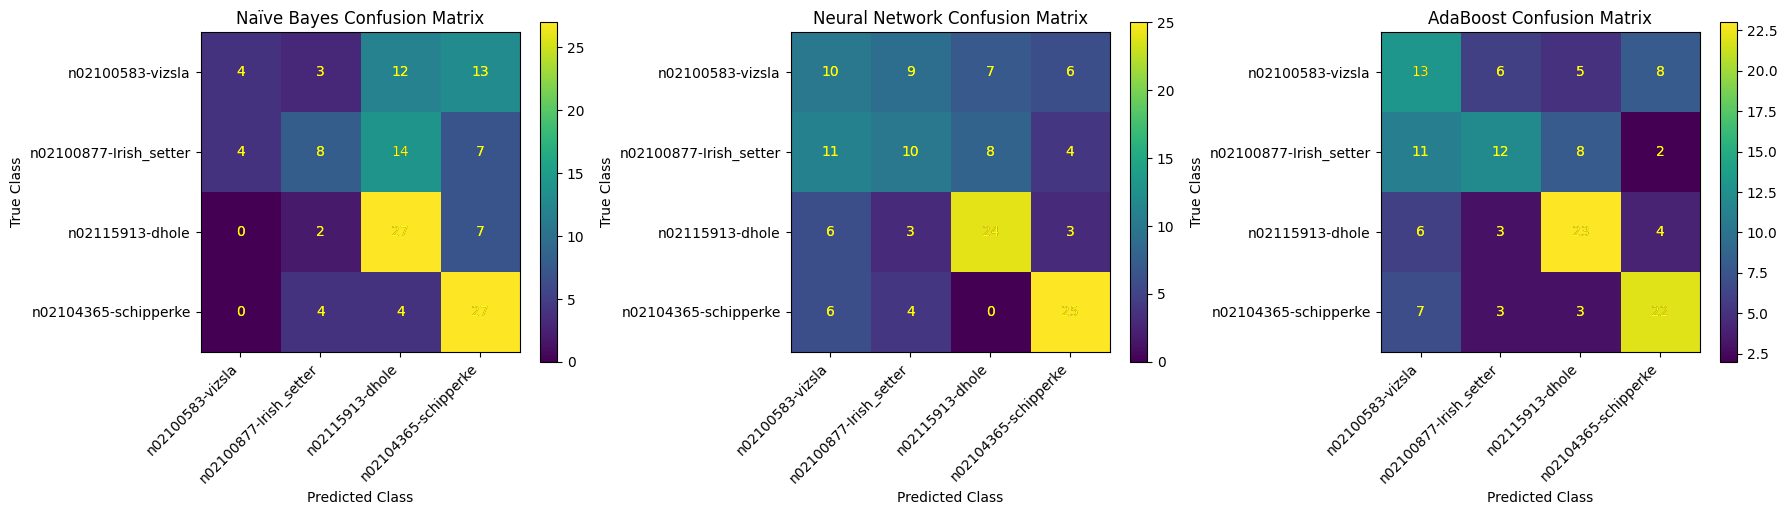

In [4]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

# https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.GaussianNB.html
# https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPClassifier.html
# Initialize classifiers
nb_classifier = GaussianNB()
nn_classifier = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=300, random_state=42)
ab_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Dictionary to store classifiers
classifiers = {
    "Naïve Bayes": nb_classifier,
    "Neural Network": nn_classifier,
    "AdaBoost": ab_classifier
}

# Stratified 5-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

# Perform cross-validation and print results
for name, clf in classifiers.items():
    cv_score = cross_val_score(clf, train_images_standardized, train_labels, cv=skf, scoring='accuracy')
    cv_scores[name] = cv_score
    print(f"{name} Cross-Validation Accuracy: {cv_score.mean():.4f} ± {cv_score.std():.4f}")

# Plot confusion matrices for each classifier
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cmap = plt.cm.viridis  # Use a similar colormap to match the example image

for idx, (name, clf) in enumerate(classifiers.items()):
    # Train the classifier on the full training data
    clf.fit(train_images_standardized, train_labels)
    
    # Predict on the test data
    test_predictions = clf.predict(test_images_standardized)
    
    # Generate and plot the confusion matrix
    cm = confusion_matrix(test_labels, test_predictions, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=axes[idx], cmap=cmap, colorbar=True)
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_xlabel("Predicted Class")
    axes[idx].set_ylabel("True Class")
    
    # Set the x-tick labels at an angle for better visibility
    axes[idx].set_xticklabels(classes, rotation=45, ha='right')

    # Add counts to each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[idx].text(j, i, cm[i, j], ha="center", va="center", color="yellow")

plt.tight_layout()
plt.show()

By visually comparing (e.g., looking at the color on the diagonal values, etc.) the three confusion matrices (on the test set), which do you think is the best method? Why?

Based on the outcomes of the confusion matrices for Naïve Bayes, Neural Network and AdaBoost it is clear that the AdaBoost is most suitable for classification in this study. This conclusion is based on the exercise in which the colors in diagonal of each matrix is brighter if the classification was correct. Looking at the matrix of AdaBoost we can see darker colours along the diagonal meaning that it makes more correct predictions compared to other models. AdaBoost has outperformed both Naïve Bayes and Neural Network but it is important to note that compared to the other algorithms Naïve Bayes had the highest misclassifications.

Based on the mean validation accuracies (from the 5-fold cross-validation) for the three methods.Which is the best method?

In [5]:
# After cross-validation loop
# Assuming cv_scores contains the accuracies of each classifier
best_classifier = None
best_accuracy = 0

# Print mean accuracies and determine the best method
print("\nMean Validation Accuracies:")
for name, scores in cv_scores.items():
    mean_accuracy = scores.mean()
    std_accuracy = scores.std()
    print(f"{name}: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

    # Check for the best accuracy
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_classifier = name

# Print the best classifier
print(f"\nBest Classifier: {best_classifier} with Mean Accuracy: {best_accuracy:.4f}")


Mean Validation Accuracies:
Naïve Bayes: 0.3619 ± 0.0152
Neural Network: 0.4234 ± 0.0412
AdaBoost: 0.4067 ± 0.0230

Best Classifier: Neural Network with Mean Accuracy: 0.4234


Compute the accuracies for the three methods on the test set. Which is the best method?

In [6]:
from sklearn.metrics import accuracy_score

# Initialize a dictionary to store test accuracies
test_accuracies = {}

# Train each classifier on the full training data and evaluate on the test set
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(train_images_standardized, train_labels)
    
    # Predict on the test data
    test_predictions = clf.predict(test_images_standardized)
    
    # Calculate accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    test_accuracies[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy:.4f}")

# Determine the best method based on test accuracies
best_method = max(test_accuracies, key=test_accuracies.get)
best_accuracy = test_accuracies[best_method]

print(f"\nBest Method: {best_method} with Test Accuracy: {best_accuracy:.4f}")

Naïve Bayes Test Accuracy: 0.4853
Neural Network Test Accuracy: 0.5074
AdaBoost Test Accuracy: 0.5147

Best Method: AdaBoost with Test Accuracy: 0.5147


Compute the F-measure for the three methods on the test set. Which is the best method?

In [7]:
from sklearn.metrics import f1_score

# Initialize a dictionary to store F-measures
f_measures = {}

# Train each classifier on the full training data and evaluate on the test set
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(train_images_standardized, train_labels)
    
    # Predict on the test data
    test_predictions = clf.predict(test_images_standardized)
    
    # Calculate F-measure (F1 Score)
    f1 = f1_score(test_labels, test_predictions, average='weighted')  # Use 'weighted' for multi-class
    f_measures[name] = f1
    print(f"{name} F-measure: {f1:.4f}")

# Determine the best method based on F-measures
best_method = max(f_measures, key=f_measures.get)
best_f_measure = f_measures[best_method]

print(f"\nBest Method: {best_method} with F-measure: {best_f_measure:.4f}")

Naïve Bayes F-measure: 0.4346
Neural Network F-measure: 0.5003
AdaBoost F-measure: 0.5127

Best Method: AdaBoost with F-measure: 0.5127


7)(Model Selection) Use images from TWO classes. Perform a standard 5-fold cross-validation and a stratified 5-fold cross-validation on the training set (i.e., the standardized edge histogram dataset obtained from the training set) for Support Vector Classifiers using LinearSVC such that parameter 𝐶 = 0.1, 1, 10, 100 and other parameters set as default

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
import numpy as np

# Select two classes for this task
selected_classes = ['n02100583-vizsla', 'n02100877-Irish_setter']  # Example classes
selected_indices = np.where((train_labels == selected_classes[0]) | (train_labels == selected_classes[1]))[0]
selected_images = train_images_standardized[selected_indices]
selected_labels = train_labels[selected_indices]

# Values for the C parameter
C_values = [0.1, 1, 10, 100]

# Initialize KFold and StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to perform cross-validation
def evaluate_model(cv_method, images, labels, c_values):
    results = {}
    for c in c_values:
        classifier = LinearSVC(C=c, random_state=42)
        scores = cross_val_score(classifier, images, labels, cv=cv_method, scoring='accuracy')
        results[c] = scores.mean()
    return results

# Perform standard 5-fold cross-validation
standard_cv_results = evaluate_model(kf, selected_images, selected_labels, C_values)
print("Standard 5-Fold CV Results:")
for c, acc in standard_cv_results.items():
    print(f"C={c}: Accuracy={acc:.4f}")

# Perform stratified 5-fold cross-validation
stratified_cv_results = evaluate_model(skf, selected_images, selected_labels, C_values)
print("Stratified 5-Fold CV Results:")
for c, acc in stratified_cv_results.items():
    print(f"C={c}: Accuracy={acc:.4f}")


Standard 5-Fold CV Results:
C=0.1: Accuracy=0.4900
C=1: Accuracy=0.4862
C=10: Accuracy=0.4900
C=100: Accuracy=0.4900
Stratified 5-Fold CV Results:
C=0.1: Accuracy=0.4781
C=1: Accuracy=0.4667
C=10: Accuracy=0.4667
C=100: Accuracy=0.4667


Plot a graph (x-axis: 𝐶; y-axis: mean validation/training error (%)) containing four error curves (2 validation error curves and 2 training error curves - label them clearly using a legend to define the curves). Which 𝐶 has/have the lowest mean error for each curve? Comment about (1) the model complexity for SVM in relation to 𝐶, and (2) when/whether there is overfitting/underfitting.

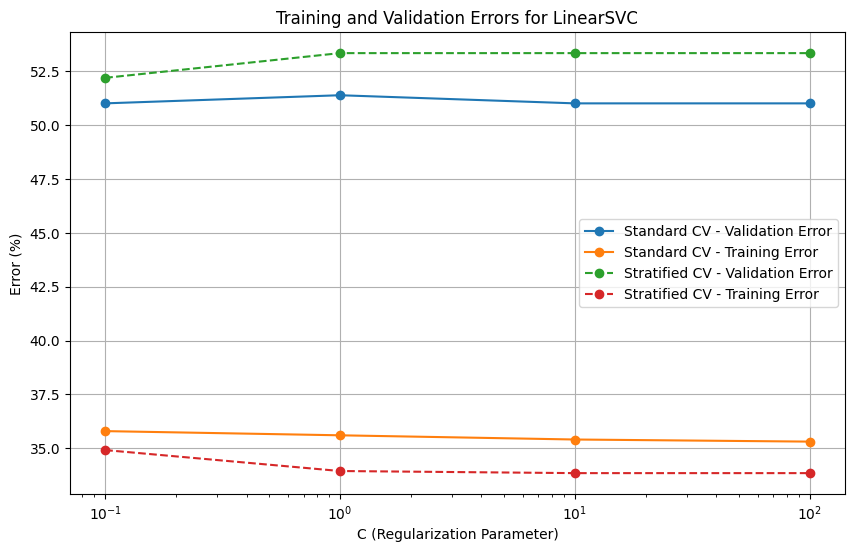

In [11]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import clone

# Function to perform cross-validation and return mean validation and training errors
def evaluate_model_errors(cv_method, images, labels, c_values):
    validation_scores = {}
    training_scores = {}
    for c in c_values:
        val_scores = []
        train_scores = []
        classifier = LinearSVC(C=c, max_iter=10000, random_state=42)
        
        for train_index, test_index in cv_method.split(images, labels):
            clf = clone(classifier)
            X_train, X_test = images[train_index], images[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            clf.fit(X_train, y_train)
            train_accuracy = clf.score(X_train, y_train)
            test_accuracy = clf.score(X_test, y_test)
            
            train_scores.append(1 - train_accuracy)
            val_scores.append(1 - test_accuracy)
        
        validation_scores[c] = np.mean(val_scores)
        training_scores[c] = np.mean(train_scores)
        
    return validation_scores, training_scores

# Calculate errors using both standard and stratified 5-fold cross-validation
standard_val_errors, standard_train_errors = evaluate_model_errors(kf, selected_images, selected_labels, C_values)
stratified_val_errors, stratified_train_errors = evaluate_model_errors(skf, selected_images, selected_labels, C_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, [standard_val_errors[c] * 100 for c in C_values], marker='o', label='Standard CV - Validation Error')
plt.plot(C_values, [standard_train_errors[c] * 100 for c in C_values], marker='o', label='Standard CV - Training Error')
plt.plot(C_values, [stratified_val_errors[c] * 100 for c in C_values], marker='o', linestyle='--', label='Stratified CV - Validation Error')
plt.plot(C_values, [stratified_train_errors[c] * 100 for c in C_values], marker='o', linestyle='--', label='Stratified CV - Training Error')

plt.title('Training and Validation Errors for LinearSVC')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Error (%)')
plt.xscale('log')  # Use logarithmic scale for better visibility of different C values
plt.legend()
plt.grid(True)
plt.show()


Lowest Mean Error for Each Curve:
1. Standard CV - Validation Error: Lowest at C = 10
2. Standard CV - Training Error: Lowest at C = 10  (almost constant across higher values of C)
3. Stratified CV - Validation Error: Lowest at  C = 10 
4. Stratified CV - Training Error: Lowest at  C = 10  (and decreasing slightly as C increases)

Model Complexity in Relation to C:
1. Complexity of SVM with C:
   - The c parameter in SVM acts as a regularization parameter, where a smaller C value leads to a higher bias and lower variance, effectively a simpler model. Conversely, a larger C value reduces the bias but increases the variance, leading to a more complex model.
   - In this case, as C increases from 0.1 to 100, the model becomes more complex. This is observed with the training errors decreasing, indicating that the model is fitting the training data more closely.

Overfitting/Underfitting:
1. Indications of Overfitting:
   - Overfitting would be indicated if the training error is significantly lower than the validation error. However, in the graph, there is no significant difference between the training and validation errors as C increases, suggesting that the model has not begun to overfit within the range of C values tested.
   - The training error remains flat and low, especially for higher values of C, which suggests that the model is fitting well without major overfitting issues.

2. Indications of Underfitting:
   - Underfitting would be indicated by high errors on both training and validation data. At C=0.1, both errors are slightly higher compared to other C values, suggesting mild underfitting where the model is too simple to capture the underlying patterns adequately.

In conclusion, the model with C=10 generally performs best across both standard and stratified cross-validation, offering a good balance between complexity and performance without significant overfitting or underfitting. For this dataset and task, further increasing C does not provide substantial benefits and keeps the error stable, suggesting that c=10 might be a sufficient regularization strength to achieve optimal performance.

In [15]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier with the selected C value
optimal_c = 10
svm_classifier = LinearSVC(C=optimal_c, random_state=42, max_iter=10000)

# Train the classifier on the full standardized training dataset
svm_classifier.fit(train_images_standardized, train_labels)

# Predict on the standardized test dataset
test_predictions = svm_classifier.predict(test_images_standardized)

# Calculate the test error
test_accuracy = accuracy_score(test_labels, test_predictions)
test_error = 1 - test_accuracy

# Print the test error
print(f"Test Error for LinearSVC with C={optimal_c}: {test_error:.4f}")

Test Error for LinearSVC with C=10: 0.5000
